# CONTEXTO DO PROBLEMA

A Blocker Fraude Company é uma empresa especializada na detecção de fraudes em transações financeiras feitas através de dispositivos móveis. A empresa tem um serviço chamado “Blocker Fraud” no qual garante o bloqueio de transações fraudulentas.

E o modelo de negócio da empresa é do tipo Serviço com a monetização feita por performance do serviço prestado, ou seja, o usuário paga uma taxa fixa sobre o sucesso na detecção de fraude das transações do cliente.

Porém, a Blocker Fraud Company está em fase de expansão no Brasil e para adquirir clientes mais rapidamente, ela adotou uma estratégia muito agressiva. A estratégia funciona da seguinte forma:

1. A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.
2. A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.
3. A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.


Com essa estratégia agressiva a empresa assume os riscos em falhar na detecção de fraude e é remunerada na detecção assertiva das fraudes.

Para o cliente, é um excelente negócio contratar a Blocker Fraud Company. Apesar da taxa cobrada ser muito alta sobre o sucesso, 25%, a empresa reduz seus custos com transações fraudulentas detectadas corretamente e ainda o prejuízo causado por um erro do serviço de anti-fraude será coberto pela própria Blocker Fraud Company.

Para a empresa, além de conseguir muitos clientes com essa estratégia arriscada em garantir o reembolso no caso de uma falha na detecção de fraude do cliente, ela depende somente da precisão e da acurácia dos modelos construídos pelos seus Cientistas de Dados, ou seja, quanto mais preciso for o modelo “Blocker Fraud”, maior o faturamento da empresa. Porém, se o modelo tiver baixa precisão, a empresa poderá ter um prejuízo enorme.

# O PROBLEMA

Você foi contratado como um Consultor de Ciência de Dados para criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

Ao final da sua consultoria, você precisa entregar ao CEO da Blocker Fraud Company um modelo em produção no qual seu acesso será feito via API, ou seja, os clientes enviarão suas transações via API para que o seu modelo as classifique como fraudulentas ou legítimas.

Além disso, você precisará entregar um relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu. No seu relatório deve conter as respostas para as seguintes perguntas:

1. Qual a Precisão e Acurácia do modelo?
2. Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
3. Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
4. Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
5. Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

# ENTENDIMENTO DO PROBLEMA

**Motivação:** Alta estratégia de crescimento para expansão sobre os resultados de detecção das fraudes.

**Causa Raiz do Problema:** Criar um modelo capaz de detectar fraudes com alta acuracia.

**Tipo de Problema:** Detecção de Fraude.

**Potênciais Métodos:** Classificação.

**Granularidade:** Classificação de Fraude por Transação.

**Entraga da Solução:** WebApp contendo a predição e o Relatório.

**Dados para Resolver o Problema:** [Kaggle](https://www.kaggle.com/ealaxi/paysim1).

# 0.0 IMPORTS

In [1]:
# Manipulation
import pandas as pd
import inflection

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Math and statistic
import numpy as np
from scipy import stats

# Preparation ML
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE

# Models ML
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

# split data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Metrics ML
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

# Test deploy
import json
import requests

# others
import warnings
import random
import pickle

## 0.1 Funções Auxiliares

In [2]:
# configurations
warnings.filterwarnings('ignore') # ignore warnings
palette = ['#67b79e', '#fda664', '#e0d124', '#84b295', '#f6eee0']   # color to data visualization


# correlation categories
def cramer_v(x, y):
    
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) **2 / (n-1)
    rcorr = r - (r-1) **2 / (n-1)
    
    return np.sqrt((chi2_corr / n) / (min(kcorr-1, rcorr-1)))


# Show matrix correlation
def show_matrix(col, data, output='list'):

    rows = []
    index = []
    columns = []

    for c in data.columns:

        result = cramer_v(x=data[str(col)], y=data[str(c)])

        rows.append(result)
        index.append(str(c))
        columns.append(str(col))
        
    if output == 'list':
        return rows
    
    elif output == 'dict':
        return pd.DataFrame(rows, index=index, columns=[str(col)])
    
    
def plot_boxplot(x1, x2, x3, data):
    
    """
    A função recebe 3 series.
    Retorna 3 plot de boxplot nas mesma linha.
    """
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.boxplot(x=x1, color=palette[0])
    
    plt.subplot(1, 3, 2)
    sns.boxplot(x=x2, color=palette[0])
    
    plt.subplot(1, 3, 3)
    sns.boxplot(x=x3, color=palette[0])
        
    
def compute_metrics(yhat, y_validation, model_name):
    
    metric = pd.DataFrame(
        {'Model_name': model_name,
         'Balanced_accuracy': balanced_accuracy_score(y_validation, yhat),
         'Precision': precision_score(y_validation, yhat),
         'Recall': recall_score(y_validation, yhat)
        }, index=[0])
    
    return metric


def cross_validation(model_name, x, y, model, cv, verbose=True):
    
    '''
    A função recebe o nome do modelo, modelo, dados,
    numero de folds e o numero de pessoas da base ordenada e retorna um
    dataframe com as métricas precision recall e acuracia.
    
    model_name=nome do modelo, x=features, y=target, model=modelo instanciado,
    cv=folds
    '''
    
    kfold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    metric_precision = []
    metric_recall = []
    metric_accuracy = []
    metric_balanced_accuracy = []
    k = 0
    
    for train, val in kfold.split(x, y):
    
        k += 1
        if verbose:
            print(f'Number KFold: {k}/{cv}')

        # Split training
        x_train = x.iloc[train]  # features to training
        y_train = y.iloc[train]  # target to training
        
        # Split validation
        x_val = x.iloc[val]  # features to validation
        y_val = y.iloc[val]  # target to validation
    

        # Model training
        model_trained = model.fit(x_train, y_train)
        yhat_model = model_trained.predict(x_val)

        # Performance
        metric_recall.append(recall_score(y_val, yhat_model))       # compute recall 
        metric_precision.append(precision_score(y_val, yhat_model)) # compute precision
        metric_balanced_accuracy.append(balanced_accuracy_score(y_val, yhat_model)) # compute balanced accuracy
        
    df_metric = pd.DataFrame(
        {'Model_name': model_name,
         'Balanced_accuracy': np.round(np.mean(metric_balanced_accuracy), 2).astype(str) + ' +/- ' + np.round(np.std(metric_balanced_accuracy), 5).astype(str),
         'Precision': np.round(np.mean(metric_precision), 2).astype(str) + ' +/- ' + np.round(np.std(metric_precision), 5).astype(str), 
         'Recall': np.round(np.mean(metric_recall), 2).astype(str) + ' +/- ' + np.round(np.std(metric_recall), 5).astype(str)}, index=[0]
    )
    
    return df_metric


def plot_metric(y_true, yhat, model_name):
    
    matrix = confusion_matrix(y_true, yhat)

    # show metric
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(matrix, annot=True, cmap='Greens')
    plt.title(f'Confusion Matrix - {model_name}')

    # figure with real data
    plt.subplot(1, 3, 2)
    sns.barplot(x=y_true.value_counts().index, y=y_true.value_counts().values, palette=palette)
    plt.title('Fraud - Real')
    plt.xlabel('Fraud')
    sns.despine(right=True)

    # figure with prediction
    plt.subplot(1, 3, 3)
    pred = pd.Series(yhat).value_counts()
    sns.barplot(x=pred.index, y=pred.values, palette=palette)
    plt.title('Fraud - Prediction')
    plt.xlabel('Prediction')
    sns.despine(right=True);

## 0.2 Carregamento de Dados

In [3]:
df = pd.read_csv('../data/fraud_data.csv') # load data

df.head() # show data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [4]:
print(f'Qty. Rows: {df.shape[0]}')
print(f'Qty. Columns: {df.shape[1]}')

Qty. Rows: 6362620
Qty. Columns: 11


## 1.2 Renomeação de Colunas

In [4]:
# Snakecase
snakecase = lambda x: inflection.underscore(x)

# Alter name columns
df.columns = list(map(snakecase, list(df.columns)))
df.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Tipo de Dados

In [47]:
df.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

## 1.4 Verificação de Dados Ausentes

In [48]:
df.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

## 1.5 Estatística Descritiva

### 1.5.1 Atributos Numéricos

In [8]:
numerical = df.select_dtypes(include=['int64', 'float64'])  # Select numerical data
describe = numerical.describe().T  # describe data

describe['kurtosis'] = numerical.apply(lambda x: x.kurtosis())  # add kurtosis in describe
describe['skew'] = numerical.apply(lambda x: x.skew())  # add skew in describe

describe

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,0.329071,0.375177
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,1797.956705,30.993949
oldbalance_org,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,32.964879,5.249136
newbalance_orig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,32.066985,5.176884
oldbalance_dest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,948.674125,19.921758
newbalance_dest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,862.156508,19.352302
is_fraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00,769.702982,27.779538
is_flagged_fraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00,397659.062500,630.603629


**Insight:**

<ins>Distribuição</ins>: Há pessoas que fizeram transação com valor de 0 no total, e pessoas que fizeram transação sem dinheiro na conta. O valor máximo de uma transação foi de 92 milhões, um range de transações muito grande.No geral todas as variaveis numéricas estão com um range grande com valores muito altos e nenhuma está seguindo uma distribuição normal.

<ins>Negócio</ins>: A média do valor das transações é de 100 mil, valores extremos aumentaram o valor da transação média. 50% das transações são feitas em cerca de 74 mil e 50% das contas de quem fez a transação restou 14 mil de saldo final. Em relação a fraude, mias de 75% dos casos são de transações legais e dentro do padrão. 

### 1.5.2 Atributos Categóricos

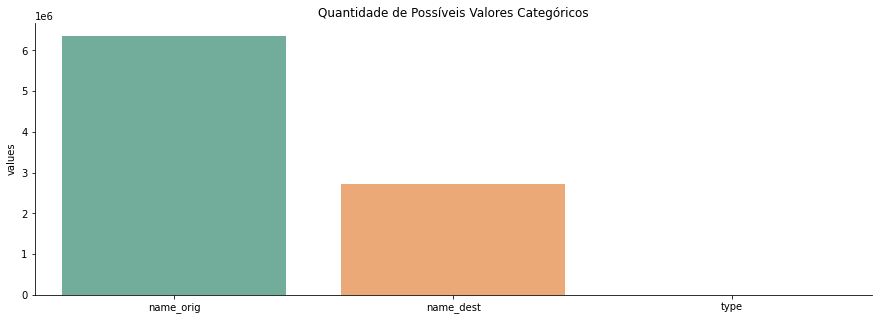

In [9]:
# Select categorical data
categorical = df.select_dtypes(include=['object'])

# Count unique values 
values_cat = categorical.apply(lambda x: len(x.unique())).sort_values(ascending=False)

# Figure
plt.figure(figsize=(15, 5))
sns.barplot(x=values_cat.index, y=values_cat.values, palette=palette)
sns.despine(right=True)
plt.ylabel('values')
plt.title('Quantidade de Possíveis Valores Categóricos');

**Insight:**

Os atributos categóricos possuem um grande range de possíveis valores, com exceção do tipo da transação. Há posucos tipos de transações e há mais nomes de pessoas que fazem a transação do que pessoas que recebem a transação.

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa Mental de Hipóteses

<p align="center">
  <img src="../img/mind_map.png" width="1000" title="mind-map">
</p>

## 2.2 Hipóteses

### 2.2.1 Hipóteses Período

**1.** Fraudes acontecem mais no final de semana.

**2.** Fraudes acontecem mais em época de Black Friday.

**3.** Fraudes acontecem mais em feriados.

### 2.2.2 Hipóteses Transação

**1.** Fraudes acontecem mais em pagamentos de crédito.

**2.** Transações maiores que 50% do saldo bancario são fraudes.

**3.** A maior parte de transações feitas superior que 80mil, são fraudes.

**4.** Contas de origem que ficaram zeradas após as transações, são fraudes.

### 2.2.3 Hipóteses Cliente

**1.** Há maior quantidade de fraudes em contas de pessoas físicas.

**2.** Há maior quantidade de fraudes em contas de pessoas com alto poder aquisitivo.

**3.** Há maior quantidade de fraudes em transações de pessoa física para juridica.

## 2.3 Lista Final de Hipóteses

**1.** Fraudes acontecem mais em pagamentos de crédito.

**2.** Transações maiores que 50% do saldo bancario são fraudes.

**3.** A maior parte de transações feitas superior que 80mil, são fraudes.

**4.** Contas de origem que ficaram zeradas após as transações, são fraudes.

**5.** Há maior quantidade de fraudes em contas de pessoas com alto poder aquisitivo.

**6.** Há maior quantidade de fraudes em transações de pessoa física para juridica.

## 2.3 Feature Engineering

In [5]:
# Copy dataframe
df2 = df.copy()

# greater_50 - describe if the transaction is greater than 50% of the balance (yes or no)
df2['greater_50%'] = df2[['amount', 'oldbalance_org']].apply(
    lambda x: 'yes' if x['amount'] / 2 > x['oldbalance_org'] else 'no', axis=1
    )

# purchasing_power_org - describe the purchasing power of the origin transaction
average_salary = 3400
median_salary = df2['oldbalance_org'].median()

df2['purchasing_power_org'] = df2['oldbalance_org'].apply(
    lambda x: 'low' if x <= average_salary else 'average' 
                    if x > average_salary and x <= median_salary else 'high'
                )

# type_transaction - describe the type of transaction C = Customer and M = Merchants
df2['type_transaction'] = df2[['name_orig', 'name_dest']].apply(
    lambda x: 'C to C' if x['name_orig'][0] == 'C' and x['name_dest'][0] == 'C' else 'M to M' 
                       if x['name_orig'][0] == 'M' and x['name_dest'][0] == 'M' else 'C to M' 
                       if x['name_orig'][0] == 'C' and x['name_dest'][0] == 'M' else 'M to C' 
                       if x['name_orig'][0] == 'M' and x['name_dest'][0] == 'C' else None, axis=1
                    )

# type_amount - Describe is amount is greater than 80K (greater or less)
df2['type_amount'] = df2['amount'].apply(lambda x: 'greater' if x > 80000 else 'less')

# 3.0 FILTRAGEM DE DADOS

Não foi necessário filtrar dados, pois o escopo do problema não há limitações no momento da predição do modelo.

# 4.0 EDA

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

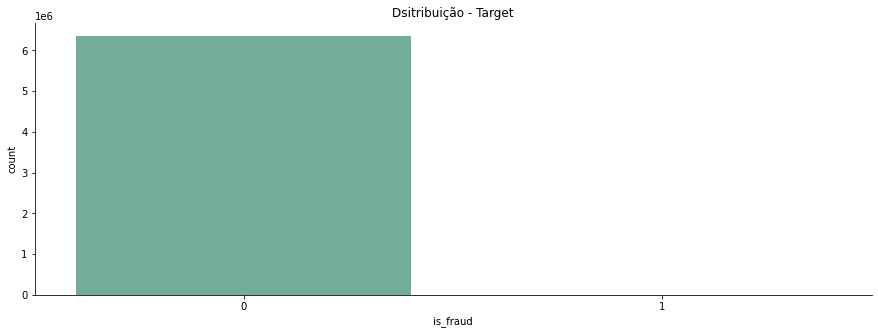

In [6]:
# Copy dataframe
df4 = df2.copy()

# Figure 
plt.figure(figsize=(15, 5))
sns.countplot(x='is_fraud', data=df4, palette=palette)
sns.despine(right=True)
plt.title('Dsitribuição - Target');

**Insight:**

Apenas 1º das transações são de fraude e 99% normais. Há um alto desbalanceamento de dados, visto que há um numero muito pequeno de fraudes.

### 4.1.2 Variável Numérica

#### 4.1.2.1 Distribuição

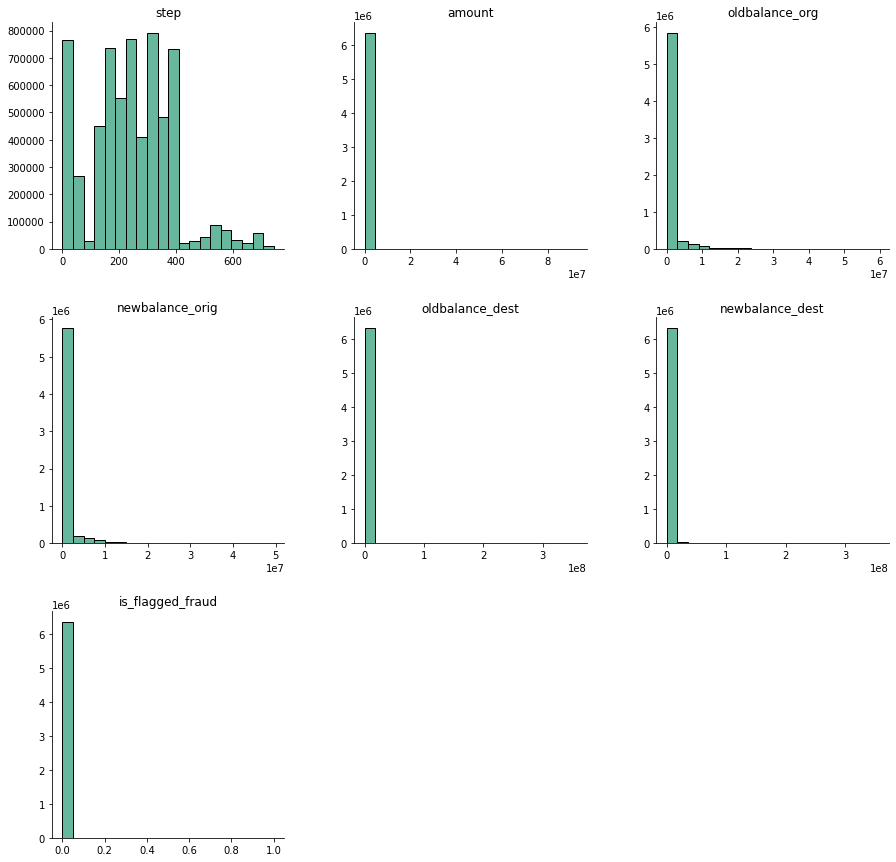

In [12]:
# Filter numerical atributes
num = df4.select_dtypes(include=['int64', 'float64']).drop(columns=['is_fraud'])

# Figure
num.hist(grid=False, bins=20, ec='k', figsize=(15, 15), color=palette[0])
sns.despine(right=True)
plt.title('Dsitribuição Variaveis Numéricas');

**Insight:**

No geral, as variavies numéricas não possuem tanto comportamento, estão com as distribuições mais concentradas em torno do zero, devido a possuir alta quantidade de informações com zero, deslocando as distribuições para a esquerda com um alto pico. A exceção é o atributo <ins>step</ins> que há maior comportamento e posui uma distribuição maior em valores entre 0 a 400. Os atributos estão longe de uma distribuição normal.

#### 4.1.2.2 Outliers

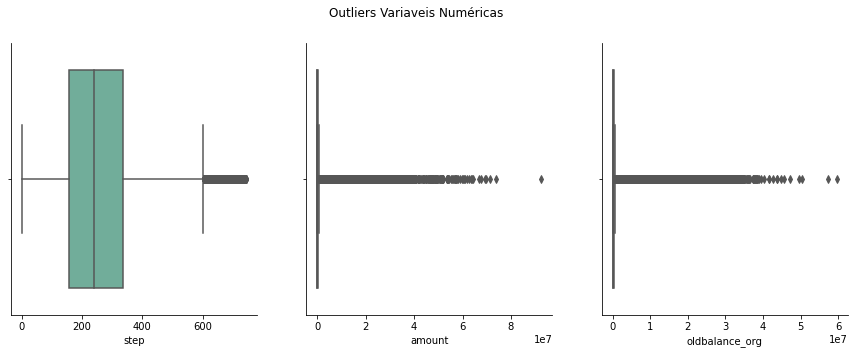

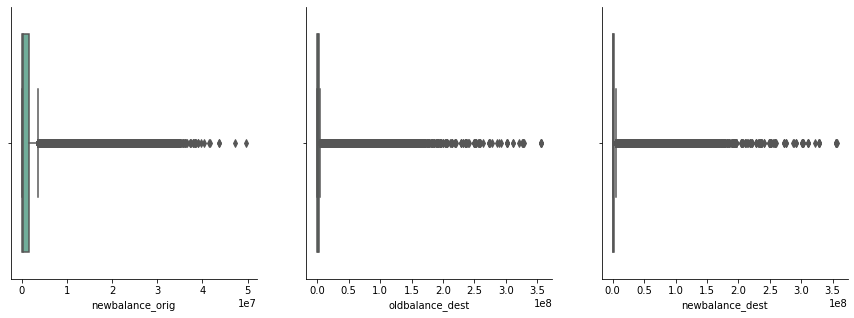

In [13]:
# Drop column
num = num.drop(columns='is_flagged_fraud')

# Filter values 
amount = num[num['amount'] > 1]['amount']
oldbalance_org = num[num['oldbalance_org'] > 1]['oldbalance_org']
newbalance_orig = num[num['newbalance_orig'] > 1]['newbalance_orig']
oldbalance_dest = num[num['oldbalance_dest'] > 1]['oldbalance_dest']
newbalance_dest = num[num['newbalance_dest'] > 1]['newbalance_dest']

# Create figures
plot_boxplot(x1=num['step'], x2=amount, x3=oldbalance_org, data=num)
plt.suptitle('Outliers Variaveis Numéricas')
sns.despine(right=True)

plot_boxplot(x1=newbalance_orig, x2=oldbalance_dest, x3=newbalance_dest, data=num)
sns.despine(right=True)

**Insight:**

Em todas as variaveis, contém média e mediana bem próximas do zero e há valores muito extremos disso. A variavel <ins>step</ins> é a que tem menos outliers e com a media e mediana distante do zero.

### 4.1.3 Variável Categórica

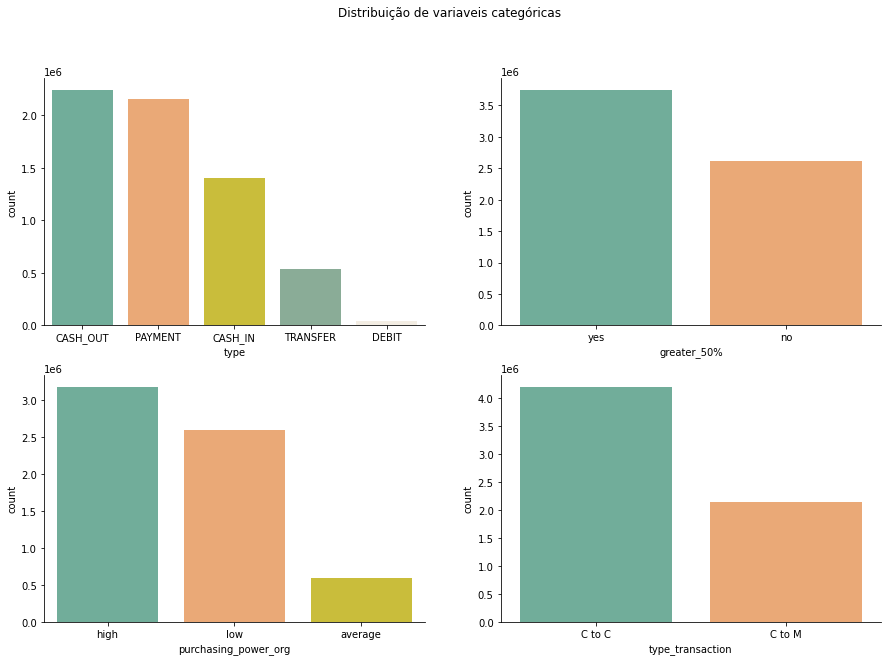

In [14]:
# Filter categorical atributes
cat = df4.select_dtypes(include=['object'])

# Figure 1
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.countplot(x='type', data=cat, order=list(cat['type'].value_counts().sort_values(ascending=False).index), palette=palette)
plt.suptitle('Distribuição de variaveis categóricas')
sns.despine(right=True)

# Figure 2
plt.subplot(2, 2, 2)
sns.countplot(x='greater_50%', data=cat, order=['yes', 'no'], palette=palette)
sns.despine(right=True)

# Figure 3
plt.subplot(2, 2, 3)
sns.countplot(x='purchasing_power_org', data=cat, palette=palette)
sns.despine(right=True)

# Figure 4
plt.subplot(2, 2, 4)
sns.countplot(x='type_transaction', data=cat, order=['C to C', 'C to M'], palette=palette)
sns.despine(right=True);

**Insight:**

A maior parte das transações são feitas de saques e de pagamentos, e a minoria é feita de débito. A maior parte das pessoas realizam transações maiores que 50% de seu saldo na conta. Também, a maior quantidade das pessoas/comercios que fazem transações possuem um alto poder aquisitivo e  grande parte das transações são de clientes para clientes.

## 4.2 Análise Bivariada

### H1.  Fraudes acontecem mais em transações de débito.

**FALSA** Fraudes acontecem mais em transações de <ins>Transferencia</ins> e <ins>Cash Out</ins>.

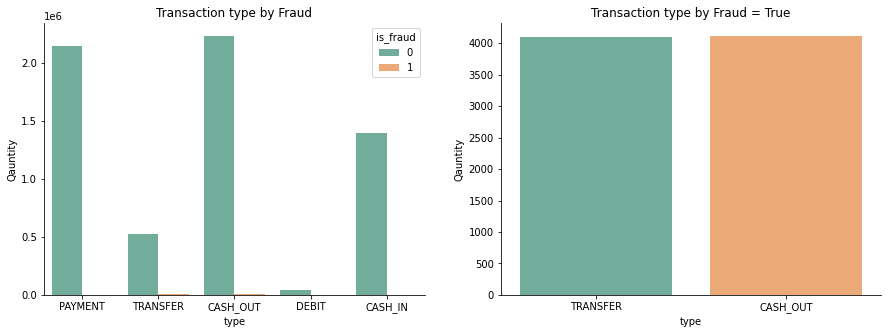

In [15]:
# figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='type', data=df4, hue='is_fraud', palette=palette)
plt.ylabel('Qauntity')
plt.title('Transaction type by Fraud')
sns.despine(right=True)

# figure 2
plt.subplot(1, 2, 2)
filter_fraud = df4[df4['is_fraud'] == 1]
sns.countplot(x='type', data=filter_fraud, palette=palette)
plt.ylabel('Qauntity')
plt.title('Transaction type by Fraud = True')
sns.despine(right=True);

### H2. Transações maiores que 50% do saldo bancario são fraudes.

**FALSA** A maior parte das transações que são maiores que 50% do saldo bancario, <ins>não</ins> são fraudes.

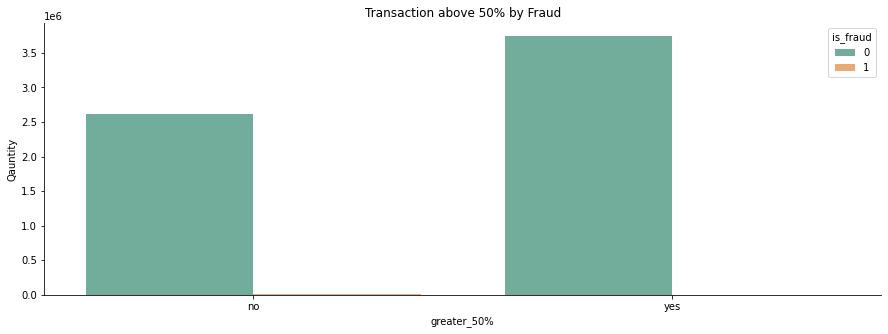

In [16]:
# create figure
plt.figure(figsize=(15, 5))
sns.countplot(x='greater_50%', data=df4, hue='is_fraud', palette=palette)
plt.ylabel('Qauntity')
plt.title('Transaction above 50% by Fraud')
sns.despine(right=True);

### H3. A maior parte de transações feitas superior que 80mil, são fraudes.

**VERDADEIRA** A maior parte das transações feitas sendo maiores que 80 mil, são fraudes.

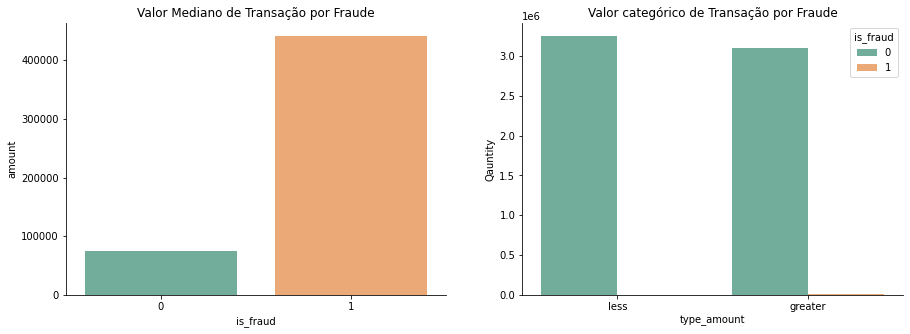

In [17]:
# Group median amount by fraud
median_group = df4['amount'].groupby(df['is_fraud']).median().reset_index()

# Figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='is_fraud', y='amount', data=median_group, palette=palette)
plt.title('Valor Mediano de Transação por Fraude')
sns.despine(right=True)

# Figure 2
plt.subplot(1, 2, 2)
sns.countplot(x='type_amount', data=df4, hue='is_fraud', palette=palette)
plt.ylabel('Qauntity')
plt.title('Valor categórico de Transação por Fraude')
sns.despine(right=True);

### H4.  Contas de origem que ficaram zeradas após as transações, são fraudes.

**FALSA** A maior parte das transações em que o saldo final da conta de origem ficou zerada, não foi fraude.

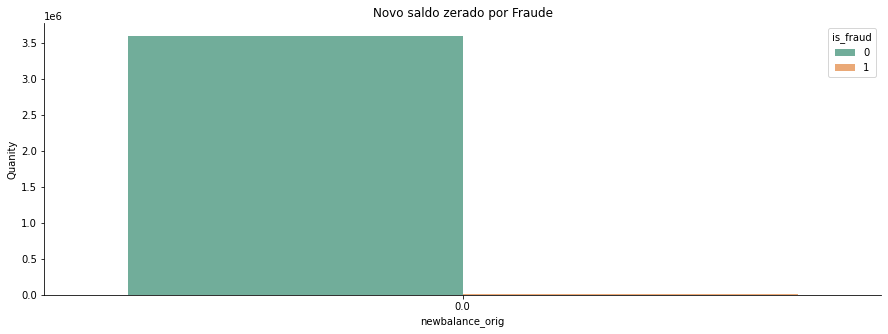

In [18]:
newbalance_orig_zero = df4[df4['newbalance_orig'] == 0]

plt.figure(figsize=(15, 5))
sns.countplot(x='newbalance_orig', data=newbalance_orig_zero, hue='is_fraud', palette=palette)
plt.ylabel('Quanity')
plt.title('Novo saldo zerado por Fraude')
sns.despine(right=True);

### H5. Há maior quantidade de fraudes em contas de pessoas com alto poder aquisitivo.

**VERDADEIRA** Há maior quantidade de fraudes em contas de pessoas com <ins>alto</ins> poder aquisitivo.

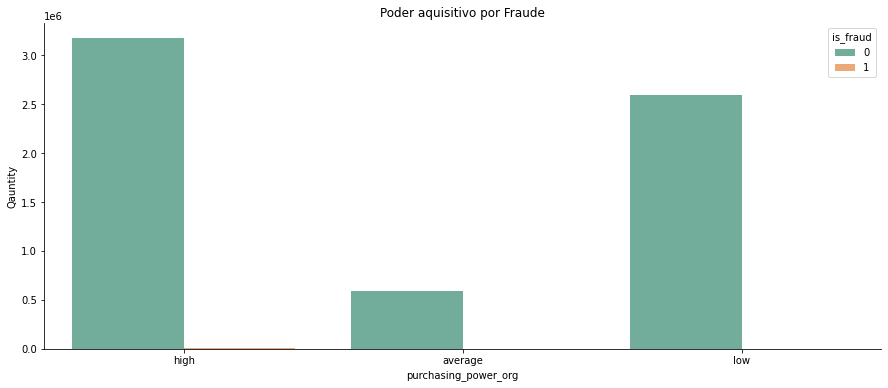

In [19]:
plt.figure(figsize=(15, 6))
sns.countplot(x='purchasing_power_org', data=df4, hue='is_fraud', order=['high', 'average', 'low'], palette=palette)
plt.title('Poder aquisitivo por Fraude')
plt.ylabel('Qauntity')
sns.despine(right=True);

### H6. Há maior quantidade de fraudes em transações de pessoa física para juridica.

**FALSA** Há maior quantidade de fraudes em transações de <ins>clientes para clientes</ins>.

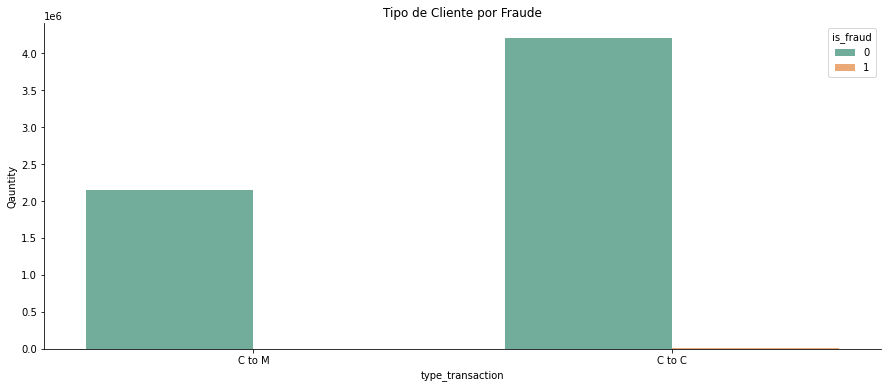

In [20]:
plt.figure(figsize=(15, 6))
sns.countplot(x='type_transaction', data=df4, hue='is_fraud', palette=palette)
plt.title('Tipo de Cliente por Fraude')
plt.ylabel('Qauntity')
sns.despine(right=True);

## 4.3 Análise Multivariada

### 4.3.1 Variável Numérica

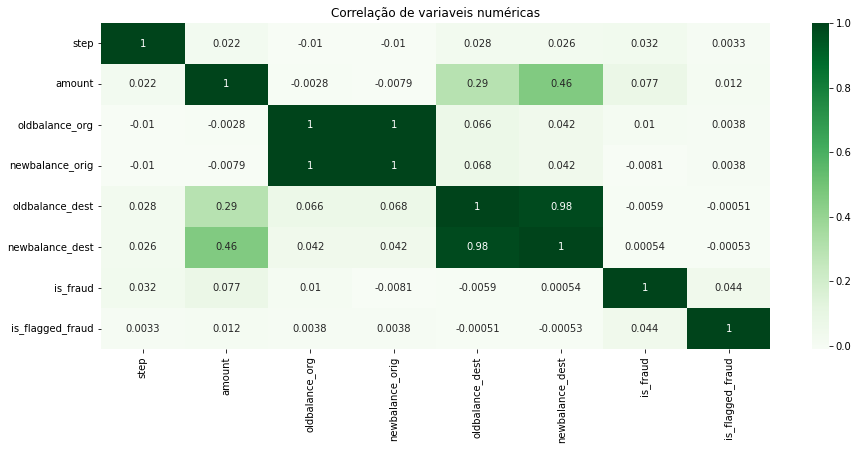

In [51]:
# filter numerical data
numerical = df4.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(15, 6))
sns.heatmap(numerical.corr(method='pearson'), annot=True, cmap='Greens')
plt.title('Correlação de variaveis numéricas');

**Insight:**

Como já esperado, há correlações entre saldo do novo balanço e o antigo junto com valor da transação.

### 4.3.2 Variável Categórica

In [ ]:
# Categorical data
categorical = df4.select_dtypes(include=['object'])

# Apply correlation categories
matrix = show_matrix(data=categorical, col='type', output='dict')
data_columns = categorical.iloc[:, 1:]

for c in data_columns.columns:
    matrix[c] = show_matrix(data=categorical, col=c, output='list')

# Figure
plt.figure(figsize=(15, 7))
sns.heatmap(matrix, annot=True, cmap='Blues')
plt.title('Correlação de Variaveis Categóricas\n', fontsize=13);

**Insight:**

# 5.0 PREPRAÇÃO DE DADOS

## 5.1 Encoding

### 5.1.1 Label Encoding

A técnica Label Encoding transforma a variavel em um range de números inteiros (sequência numérica).

In [7]:
# Copy dataframe
df5 = df4.copy()

# purchasing_power_org
df5['purchasing_power_org'] = df5['purchasing_power_org'].map({'high': 3, 'average': 2, 'low': 1})

# greater_50
df5['greater_50%'] = df5['greater_50%'].map({'no': 0, 'yes': 1})

# type_amount
df5['type_amount'] = df5['type_amount'].map({'less': 0, 'greater': 1})

### 5.1.2 One Hot Encoding

A técnica One Hot Encoding mapeia a variavel categórica com novas variaveis binárias contendo 0: representando a Não existência do valor ou 1: representando a existência do valor.

In [8]:
# type
df5 = pd.get_dummies(df5, prefix='type', columns=['type'])

# type_transaction
df5 = pd.get_dummies(df5, prefix='type_transaction', columns=['type_transaction'])

## 5.3 Reescalonamento

### 5.3.1 Min Max Scaler

A abordagem de Min Max Scaler transforma os dados para um intervalo entre 0 e 1. 

In [9]:
# Define method
mms = MinMaxScaler()

# step
df5['step'] = mms.fit_transform(df5[['step']].values)

### 5.3.2 Robust Scaler

A abordagem de Roboust Scaler transforma os dados para um intervalo entre o 1º quartil e o 3º.

In [10]:
# Define method
rs_amount = RobustScaler()
rs_oldbalance_org  = RobustScaler()
rs_newbalance_orig = RobustScaler()
rs_oldbalance_dest = RobustScaler()
rs_newbalance_dest = RobustScaler()

# amount
df5['amount'] = rs_amount.fit_transform(df5[['amount']].values)

# oldbalance_org
df5['oldbalance_org'] = rs_oldbalance_org.fit_transform(df5[['oldbalance_org']].values)

# newbalance_orig
df5['newbalance_orig'] = rs_newbalance_orig.fit_transform(df5[['newbalance_orig']].values)

# oldbalance_dest
df5['oldbalance_dest'] = rs_oldbalance_dest.fit_transform(df5[['oldbalance_dest']].values)

# newbalance_dest
df5['newbalance_dest'] = rs_newbalance_dest.fit_transform(df5[['newbalance_dest']].values)

## 5.4 Divisão de Dados

### 5.4.1 Dados de Treinamento e Validação

In [11]:
y = df5['is_fraud'].copy() # target
x = df5.drop(columns='is_fraud').copy() # features

# Split data between train and validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20)

# full training
training_full = pd.concat([x_train, y_train], axis=1)

### 5.4.2 Dados de Teste

In [12]:
test_size = 0.20 # test in 20%
sample_size = round(training_full.shape[0] * test_size) 
test_full = training_full.sample(sample_size) # get sample

# training
training = training_full.drop(list(test_full.index))
x_train = training.drop(columns='is_fraud')
y_train = training['is_fraud']

# test
x_test = test_full.drop(columns='is_fraud')
y_test = test_full['is_fraud']

# save data to report final
report_x_test = x_test.copy()

### 5.4.3 Resumo Divisão de Dados

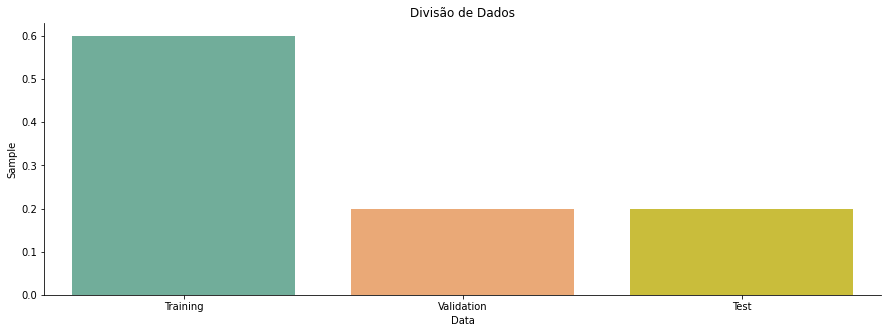

In [14]:
df_split = pd.DataFrame({
                        'Sample': [0.60, 0.20, 0.20],
                        'Data': ['Training', 'Validation', 'Test']
                        })

plt.figure(figsize=(15, 5))
sns.barplot(y='Sample', x='Data', data=df_split, palette=palette)
plt.title('Divisão de Dados')
plt.ylabel('Sample')
sns.despine(right=True);

**Insight:**

Os dados foram divididos entre treino com 60% da amostra, validação com 20% e teste com 20%. O treino será usado para o aprendizado do modelo, a validação será usada para avaliar a performance do modelo e o teste para simular os dados de produçao do mundo real.

# 6.0 SELEÇÃO DE FEATURE

## 6.1 Variavel Numérica

### 6.1.1 Low Variance

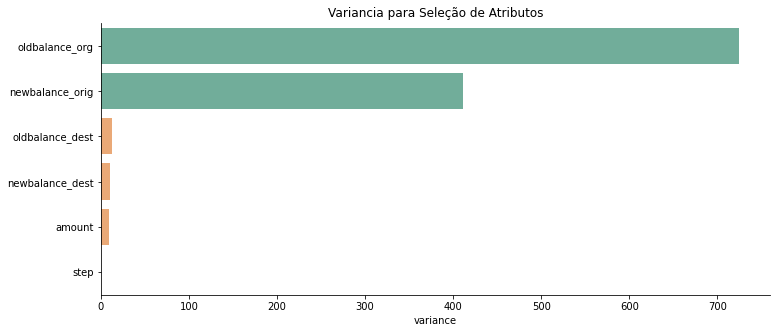

In [15]:
df6 = df5.copy() # copy dataframe
numerical = x_train.select_dtypes(include='float64') # select type float

variance_list = [] # save variace to columns
columns_list = []  # save columns name
color = [] # save colors to bar
    
for p in range(numerical.shape[1]): 
    variance = numerical.iloc[:, p].var() # calculate variance
    
    variance_list.append(variance) # variance
    columns_list.append(numerical.columns[p]) # columns

# parse variance and columns name to dataframe
df = pd.DataFrame({'columns': columns_list, 'variance': variance_list})
df = df.sort_values(by='variance', ascending=False) # order by variance

# adjust color to columns selected
for c in range(len(df)):
    
    if c in [0, 1]: color.append(palette[0])
    else: color.append(palette[1])
        
# create figure
plt.figure(figsize=(12, 5))
sns.barplot(x='variance', y='columns', data=df, palette=color)
plt.title('Variancia para Seleção de Atributos')
plt.ylabel('')
sns.despine(right=True);

**Insight:**

Nas variaveis numéricas, em termos de variação, há mais importância para o modelo as variaveis sobre quem fez a transação. No caso, o saldo que a pessoa tinha antes da transação e o saldo depois.

## 6.2 Variavel Categórica

### 6.2.1 Feature Importance

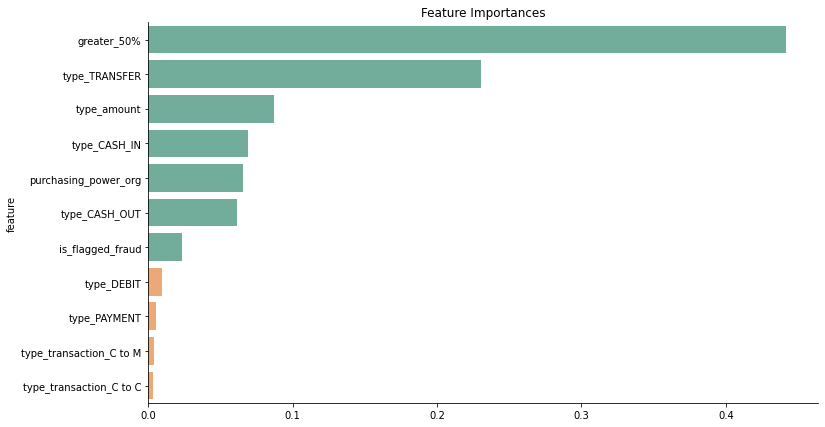

In [16]:
# select categorial and remove id
object_int = x_train.select_dtypes(include=['int64', 'uint8', 'object']).drop(columns=['name_orig', 'name_dest']).copy()

trees = ExtraTreesClassifier() # define extra trees
tree_training = trees.fit(object_int, y_train) # training extra trees

# Feature importance
importances = tree_training.feature_importances_
indices = np.argsort(importances)[::-1]

# Create dataframe with feature and importance
df = pd.DataFrame()
for i, j in zip(object_int, tree_training.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df  = pd.concat([df, aux], axis=0)

# order by imporante
df = df.sort_values(by='importance', ascending=False)

# adjust color to columns selected
color2 = []
for i in range(len(df)):
    if i in [0, 1, 2, 3, 4, 5, 6]: # position to columns selected
        color2.append(palette[0])
    else:
        color2.append(palette[1])

# Create figure to show feature importance  
plt.figure(figsize=(12, 7))
sns.barplot(y='feature', x='importance', data=df, order=df['feature'], palette=color2)
sns.despine(right=True)
plt.title('Feature Importances')
plt.xlabel('');

**Insight:**

Nas variaveis categóricas, em termos do nível de importancia, 7 das 11 variaveis tem maior importancia para o aprendizado do modelo.

## 6.3 Filtragem de Feature

In [13]:
cols_selected = ['oldbalance_org', 'newbalance_orig', 'greater_50%', 'type_TRANSFER',
                 'type_amount', 'type_CASH_OUT', 'type_CASH_IN', 'purchasing_power_org',
                 'is_flagged_fraud']

# Filter columns selected
x_train = x_train[cols_selected]
x_val = x_val[cols_selected]
x_test = x_test[cols_selected]

# show feature importance columns selected
print('Columns Selected:\n')
for c in cols_selected:
    print(c)

Columns Selected:

oldbalance_org
newbalance_orig
greater_50%
type_TRANSFER
type_amount
type_CASH_OUT
type_CASH_IN
purchasing_power_org
is_flagged_fraud


## 5.2 Desbalanceamento

### 5.2.1 Smote

A técnica Smote cria dados sintéticos da classe minoritaria (não fraude) fazendo com que as classes Fraude e Não Fraude tenham a mesma proporção. Para manter a mesma proporção, ele usa a similaridade calculando a distância dos pontos para encontrar os vizinhos mais próximos.

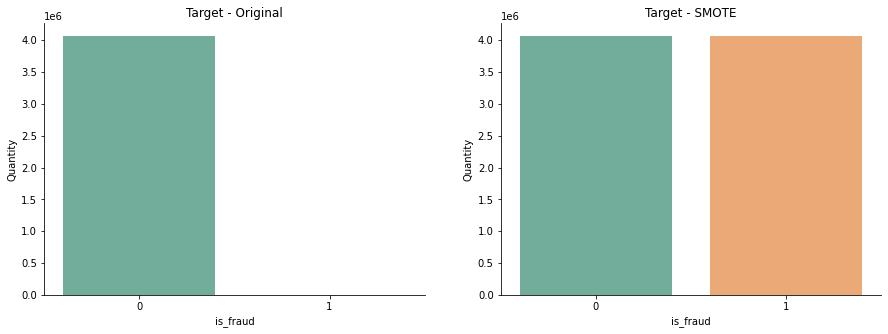

In [14]:
# define method Smote
smote = SMOTE()

x_oversample, y_oversample = smote.fit_resample(x_train, y_train) # apply smote 
training_full_smote = pd.concat([x_oversample, y_oversample], axis=1) # Merge new data

# Figure 1
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette=palette)
sns.despine(right=True)
plt.ylabel('Quantity')
plt.title('Target - Original')

# Figure 2
plt.subplot(1, 2, 2)
sns.countplot(x=y_oversample, palette=palette)
sns.despine(right=True)
plt.ylabel('Quantity')
plt.title('Target - SMOTE');

**Insight:**

Após o tratamento de desbalanceamento dos dados, a classe Não Fraude possui a mesma quantidade de exemplos da classe Fraude. Com a mesma proporção reduzimos o viés do modelo em aprender muito de uma classe apenas.

# 7.0 MACHINE LEARNING

## 7.1 Modelo Baseline

,Model_name,Balanced_accuracy,Precision,Recall
0,Baseline,0.5,0.0,0.0


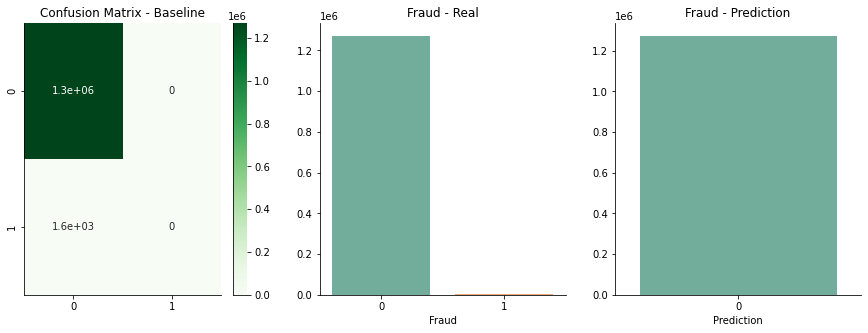

In [15]:
# define baseline model
baseline = DummyClassifier()

# model training
baseline_trained = baseline.fit(x_oversample, y_oversample)

# predict with validation
yhat_baseline = baseline_trained.predict(x_val)

# compute metric
metrics_baseline = compute_metrics(model_name='Baseline', y_validation=y_val, yhat=yhat_baseline)

# show graph
plot_metric(y_val, yhat_baseline, 'Baseline')

# show metrics
metrics_baseline

### 7.1.1 Cross Validation - Modelo Baseline

In [16]:
# Join data to cross validation
x_cross_val = pd.concat([x_oversample, x_val], axis=0)
y_cross_val = pd.concat([y_oversample, y_val], axis=0)

# apply cross validation
cross_baseline = cross_validation('Baseline', x_cross_val, y_cross_val, baseline, cv=5)
cross_baseline

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,Model_name,Balanced_accuracy,Precision,Recall
0,Baseline,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.2 Naive Bayes

,Model_name,Balanced_accuracy,Precision,Recall
0,Naive Bayes,0.875232,0.005472,0.975851


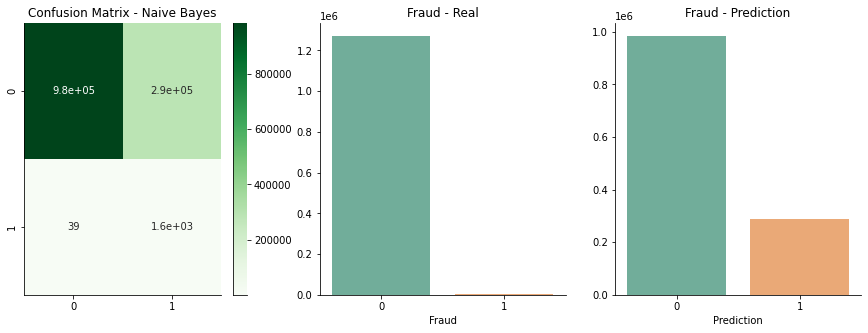

In [17]:
# define naive bayes
naive_bayes = GaussianNB()

# model training
naive_bayes_trained = naive_bayes.fit(x_oversample, y_oversample)

# predict with validation
yhat_naive_bayes = naive_bayes_trained.predict(x_val)

# compute metric
metrics_naive_bayes = compute_metrics(model_name='Naive Bayes', y_validation=y_val, yhat=yhat_naive_bayes)

# show graph
plot_metric(y_val, yhat_naive_bayes, 'Naive Bayes')

# show metrics
metrics_naive_bayes

### 7.2.1 Naive Bayes - Cross Validation

In [18]:
# apply cross validation
cross_validation_bayes = cross_validation('Naive Bayes', x_cross_val, y_cross_val, naive_bayes, cv=5)
cross_validation_bayes

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,Model_name,Balanced_accuracy,Precision,Recall
0,Naive Bayes,0.88 +/- 0.00022,0.77 +/- 0.0003,0.98 +/- 0.00012


## 7.3 Logistic Regression

,Model_name,Balanced_accuracy,Precision,Recall
0,Logistic Regression,0.964317,0.019008,0.993808


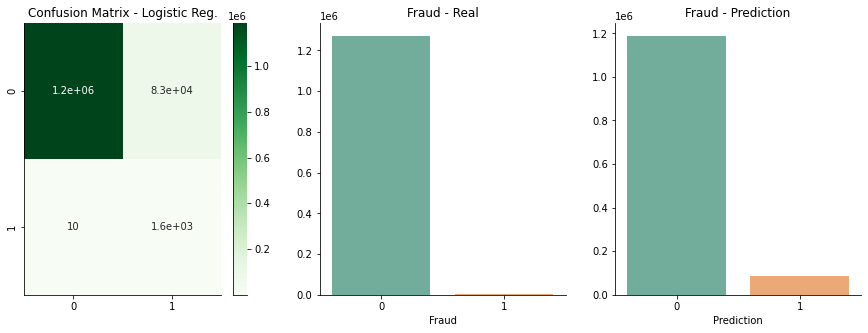

In [19]:
# define Logistic Regression
lr = LogisticRegression()

# model training
lr_trained = lr.fit(x_oversample, y_oversample)

# predict with validation
yhat_lr = lr_trained.predict(x_val)

# compute metric
metrics_lr = compute_metrics(model_name='Logistic Regression', y_validation=y_val, yhat=yhat_lr)

# show graph
plot_metric(y_val, yhat_lr, 'Logistic Reg.')

# show metric
metrics_lr

### 7.3.1 Logistic Regression - Cross Validation

In [20]:
# apply cross validation
cross_validation_lr = cross_validation('Logistic Regression', x_cross_val, y_cross_val, lr, cv=5)
cross_validation_lr

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,Model_name,Balanced_accuracy,Precision,Recall
0,Logistic Regression,0.97 +/- 0.00035,0.92 +/- 0.00075,1.0 +/- 7e-05


## 7.4 Random Forest

,Model_name,Balanced_accuracy,Precision,Recall
0,Random Forest,0.984886,0.049919,0.993808


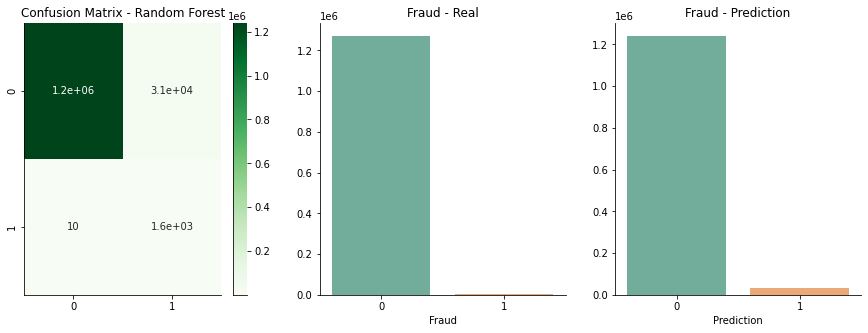

In [21]:
# define Random Forest
rf = RandomForestClassifier(max_features='sqrt', n_estimators=10, max_depth=5)

# model training
rf_trained = rf.fit(x_oversample, y_oversample)

# predict with validation
yhat_rf = rf_trained.predict(x_val)

# compute metric
metrics_rf = compute_metrics(model_name='Random Forest', y_validation=y_val, yhat=yhat_rf)

# show graph
plot_metric(y_val, yhat_rf, 'Random Forest')

# show metric
metrics_rf

### 7.4.1 Random Forest - Cross Validation

In [22]:
# apply cross validation
cross_validation_rf = cross_validation('Random Forest', x_cross_val, y_cross_val, rf, cv=5)
cross_validation_rf

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,Model_name,Balanced_accuracy,Precision,Recall
0,Random Forest,0.98 +/- 0.0034,0.96 +/- 0.00824,1.0 +/- 0.0001


## 7.5 LGBM

,Model_name,Balanced_accuracy,Precision,Recall
0,LGBM,0.985149,0.055012,0.99195


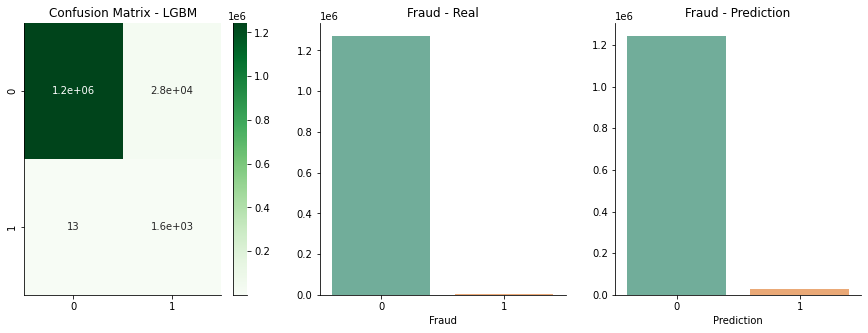

In [23]:
# define LGBM
lgbm = LGBMClassifier()

# model training
lgbm_trained = lgbm.fit(x_oversample, y_oversample)

# predict with validation
yhat_lgbm = lgbm_trained.predict(x_val)

# compute metric
metrics_lgbm = compute_metrics(model_name='LGBM', y_validation=y_val, yhat=yhat_lgbm)

# show graph
plot_metric(y_val, yhat_lgbm, 'LGBM')

# show metric
metrics_lgbm

### 7.5.1 LGBM - Cross Validation

In [24]:
# apply cross validation
cross_validation_lgbm = cross_validation('LGBM', x_cross_val, y_cross_val, lgbm, cv=5)
cross_validation_lgbm

Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5


,Model_name,Balanced_accuracy,Precision,Recall
0,LGBM,0.99 +/- 9e-05,0.97 +/- 0.00023,1.0 +/- 0.00028


## 7.6 Comparação de Performance

In [25]:
performance = pd.concat([cross_baseline, cross_validation_bayes,
                         cross_validation_lr, cross_validation_rf,
                         cross_validation_lgbm], axis=0)

performance

,Model_name,Balanced_accuracy,Precision,Recall
0,Baseline,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
0,Naive Bayes,0.88 +/- 0.00022,0.77 +/- 0.0003,0.98 +/- 0.00012
0,Logistic Regression,0.97 +/- 0.00035,0.92 +/- 0.00075,1.0 +/- 7e-05
0,Random Forest,0.98 +/- 0.0034,0.96 +/- 0.00824,1.0 +/- 0.0001
0,LGBM,0.99 +/- 9e-05,0.97 +/- 0.00023,1.0 +/- 0.00028


**Insight:**

# 8.0 AJUSTE DE HIPERPARAMETROS

A técnica de Random Search faz uma busca aleatória por parametros para encontrar a melhor combinação. O Random Search não é a técnica que obtem os melhores resultados, mas é mais rápida. Para este problema, como há um conjunto grande de dados, será usado o Random Search, devido precisar de menor poder para processamento e por levar menos tempo. 

## 8.1 Random Search

In [20]:
lgbm_parameter = {'num_leaves': [5,15,45,60,90],
                  'max_depth': [5, 7, 10 ],
                  'min_split_gain': [0.001, 0.01 ,0.1],
                  'min_child_weight': [10,30,40,50],
                  'subsample':[0.5, 1],
                  'colsample_bytree':[0.1, 1]
                 }

MAX_EVAL = 10
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    # choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in lgbm_parameter.items()}
    print(hp)
    
    # Define model
    lgbm = LGBMClassifier(
                    num_leaves=hp['num_leaves'],
                    max_depth=hp['max_depth'],
                    min_split_gain=hp['min_split_gain'],
                    min_child_weight=hp['min_child_weight'],
                    subsample=hp['subsample'],
                    colsample_bytree=hp['colsample_bytree']
    )


    # Performance
    result = cross_validation('LGBM Random Search', x_train_not_id, y_train, lgbm, cv=5)
    final_result = pd.concat([final_result, result])
    
final_result

{'num_leaves': 60, 'max_depth': 5, 'min_split_gain': 0.01, 'min_child_weight': 30, 'subsample': 1, 'colsample_bytree': 0.1}
Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5
{'num_leaves': 60, 'max_depth': 10, 'min_split_gain': 0.1, 'min_child_weight': 50, 'subsample': 0.5, 'colsample_bytree': 1}
Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5
{'num_leaves': 15, 'max_depth': 7, 'min_split_gain': 0.1, 'min_child_weight': 50, 'subsample': 1, 'colsample_bytree': 0.1}
Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5
{'num_leaves': 90, 'max_depth': 7, 'min_split_gain': 0.1, 'min_child_weight': 10, 'subsample': 0.5, 'colsample_bytree': 0.1}
Number KFold: 1/5
Number KFold: 2/5
Number KFold: 3/5
Number KFold: 4/5
Number KFold: 5/5
{'num_leaves': 60, 'max_depth': 5, 'min_split_gain': 0.001, 'min_child_weight': 40, 'subsample': 1, 'colsample_bytree': 1}
Number KFold: 1/5
Num

,Model Name,Accuracy,Precision,Recall
0,LGBM Random Search,0.97 +/- 0.00032,0.96 +/- 0.00037,0.98 +/- 0.00058
0,LGBM Random Search,0.99 +/- 0.0001,0.97 +/- 0.00028,1.0 +/- 9e-05
0,LGBM Random Search,0.97 +/- 0.00028,0.96 +/- 0.0004,0.98 +/- 0.00033
0,LGBM Random Search,0.97 +/- 0.00036,0.96 +/- 0.00036,0.98 +/- 0.00067
0,LGBM Random Search,0.99 +/- 8e-05,0.97 +/- 0.00019,1.0 +/- 5e-05
0,LGBM Random Search,0.97 +/- 0.00033,0.96 +/- 0.00033,0.98 +/- 0.00067
0,LGBM Random Search,0.97 +/- 0.00027,0.96 +/- 7e-05,0.98 +/- 0.00066
0,LGBM Random Search,0.99 +/- 0.0001,0.97 +/- 0.00027,1.0 +/- 9e-05
0,LGBM Random Search,0.99 +/- 8e-05,0.97 +/- 0.00018,1.0 +/- 4e-05
0,LGBM Random Search,0.97 +/- 0.00046,0.96 +/- 0.00101,0.97 +/- 0.0007


## 8.2 Treinamento Modelo Final

Para o treinamento do modelo final, será usado como treinamento a base de treino + validação e será avaliado com os dados de teste.

In [26]:
# define model with final parameters
lgbm_final = LGBMClassifier(max_depth=5, min_split_gain=0.1,
                            min_child_weight=40, subsample=0.5,
                            colsample_bytree= 1)

# training lgbm 
lgbm_final_trained = lgbm_final.fit(x_cross_val, y_cross_val)

## 8.3 Teste Modelo Final

,Model_name,Balanced_accuracy,Precision,Recall
0,LGBM Final,0.986991,0.057899,0.995572


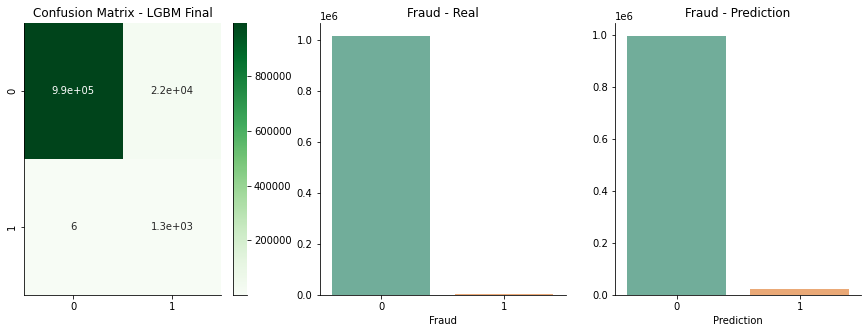

In [27]:
# predict with test data
yhat_lgbm_final = lgbm_final_trained.predict(x_test)

# comoute metrics and show
metrics_final = compute_metrics(yhat=yhat_lgbm_final, y_validation=y_test, model_name='LGBM Final')

# show graph
plot_metric(y_test, yhat_lgbm_final, 'LGBM Final')

# show metrics
metrics_final

**Insight:**

# 9.0 TRADUÇÃO E INTERPRETAÇÃO

### 1. Qual a Precisão e Acurácia do modelo?

O modelo tem **98.6%** de acurácia.

### 2. Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?

Em cerca de 1 Milhão de transações, o modelo conseguiu acertar **99.55% das fraudes**.

### 3. Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?

Em 1 Milhão de transações, se classificarmos 100% das Fraudes, o faturamento esperado é de **93 Milhões e 477 mil**. 

### 4. Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?

A cada 1 Milhão de transações o **modelo erra 0.5%** e de 1.329 transações Fraudulentas o **modelo erra 7**.

### 5. Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

Em 1 Milhão de transações, o <ins>lucro bruto</ins> é de 93 Milhões e 392 Mil e o <ins>lucro líquido</ins> por devolver 100% do valor aos 7 clientes é de **93 Milhões e 59 Mil**.

# 10.0 DEPLOY MODELO

## 10.1 Salvar Modelo

In [35]:
# Save model with pickle
pickle.dump(lgbm_final_trained, open('C:/Users/Jhonatans/projects/ML/Classification/Financial-Fraud-Detection/src/model/lgbm.pkl', 'wb'))

## 10.2 Salvar Transformações

In [ ]:
# Save transformation with pickle
pickle.dump(mms, open('C:/Users/Jhonatans/projects/ML/Classification/Financial-Fraud-Detection/src/preparation/mms_step.pkl', 'wb'))
pickle.dump(rs_amount, open('C:/Users/Jhonatans/projects/ML/Classification/Financial-Fraud-Detection/src/preparation/rs_amount.pkl', 'wb'))
pickle.dump(rs_oldbalance_org, open('C:/Users/Jhonatans/projects/ML/Classification/Financial-Fraud-Detection/src/preparation/rs_oldbalance_org.pkl', 'wb'))
pickle.dump(rs_newbalance_orig, open('C:/Users/Jhonatans/projects/ML/Classification/Financial-Fraud-Detection/src/preparation/rs_newbalance_orig.pkl', 'wb'))
pickle.dump(rs_oldbalance_dest, open('C:/Users/Jhonatans/projects/ML/Classification/Financial-Fraud-Detection/src/preparation/rs_oldbalance_dest.pkl', 'wb'))
pickle.dump(rs_newbalance_dest, open('C:/Users/Jhonatans/projects/ML/Classification/Financial-Fraud-Detection/src/preparation/rs_newbalance_dest.pkl', 'wb'))

## 10.4 Test API

In [ ]:
x_test = df.drop(columns=['isFraud']).sample(5)

# data to json
data = json.dumps(x_test.to_dict(orient='records'))

#url = 'http://127.0.0.1:5000/fraudDetection/predict' (local host)
url = 'https://api-fraud.herokuapp.com/fraudDetection/predict' # url heroku cloud
header = {'content-type': 'application/json'} # set type as json

# request with method POST
response = requests.post(url, data=data, headers=header)
print('Status code: {}'.format(response.status_code))

# json to dataframe
d1 = pd.DataFrame(response.json(), columns=response.json()[0].keys())
d1

### + Dicionario de Dados


**step**: mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

**type:** Tipo da transação.

**amount:** valor da transação em moeda local.

**nameOrig:** cliente que iniciou a transação.

**oldbalanceOrg:** saldo inicial antes da transação.

**newbalanceOrig:** Saldo depois da transação.

**nameDest:** cliente que é o destinatário da transação.

**oldbalanceDest:** destinatário do saldo inicial antes da transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**newbalanceDest:** novo destinatário do saldo após a transação. Observe que não há informações para clientes que começam com M (Comerciantes).

**isFraud:** Target.

**isFlaggedFraud:** O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.
